In [2]:
import sys
sys.path.insert(0, "/Users/rstiskalek/Projects/candel")

import numpy as np
import matplotlib.pyplot as plt
import scienceplots

import candel
from candel import SPEED_OF_LIGHT
from h5py import File

from utils import *

from scipy.stats import norm
from astropy.cosmology import FlatLambdaCDM
import seaborn as sns

%matplotlib inline
%load_ext autoreload
%autoreload 2

root = "/Users/rstiskalek/Projects/CANDEL/results/CH0"

config_path = "/Users/rstiskalek/Projects/CANDEL/scripts/runs/config_shoes.toml"
data = candel.pvdata.load_SH0ES_from_config(config_path)

2025-07-21 09:14:17 warning: zero width found in the priors. Setting it to 1e-5.
2025-07-21 09:14:17 indices of zero width: [44]
2025-07-21 09:14:17 found zero-width prior at index 44. Setting it to 0.


### Manticore-Carrick PV comparison

In [71]:
with File("/Users/rstiskalek/Projects/CANDEL/data/SH0ES/los_SH0ES_TFR_Carrick2015.hdf5", 'r') as f:
    r_C15 = f["r"][...]
    los_density_C15 = f["los_density"][...]
    los_velocity_C15 = f["los_velocity"][...]

with File("/Users/rstiskalek/Projects/CANDEL/data/SH0ES/los_SH0ES_TFR_manticore_2MPP_MULTIBIN_N256_DES_V2.hdf5", 'r') as f:
    r_Manticore = f["r"][...]
    los_density_Manticore = f["los_density"][...]
    los_velocity_Manticore = f["los_velocity"][...]


mu_host_r2_mag_sel = read_samples(root, "Cepheid_distances_no_redshift_r2_mu_SN_mag_sel.hdf5", "mu_host")
mu2r = candel.Distmod2Distance()
h = 0.7
r = mu2r(mu_host_r2_mag_sel, h=h)
r *= h
mean_r = np.mean(r, axis=0)


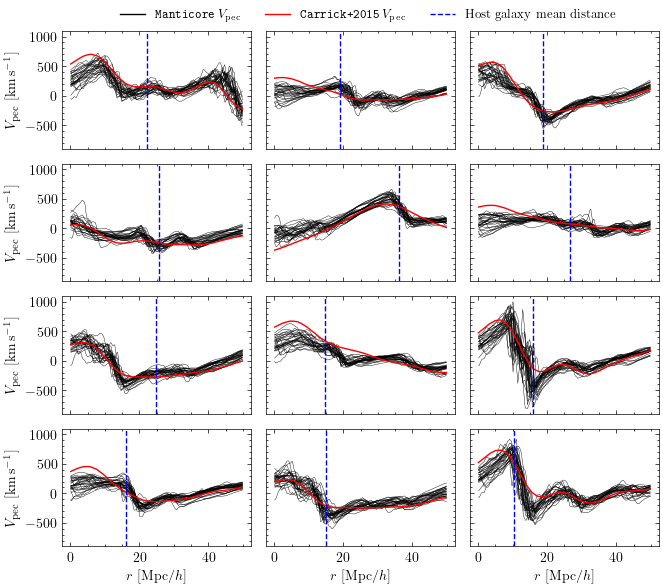

In [75]:
import matplotlib.lines as mlines

k_all = np.arange(37)
gen = np.random.default_rng(45)
k_sample = gen.choice(k_all, size=12, replace=False)

Rmax = 50
m_Manticore = r_Manticore < Rmax
m_C15 = r_C15 < Rmax

with plt.style.context("science"):
    fig, axes = plt.subplots(4, 3, figsize=(6.8, 6), sharex=True, sharey=True)
    lw = plt.rcParams['lines.linewidth']

    for idx, k in enumerate(k_sample):
        ax = axes[idx // 3, idx % 3]
        # Only label on the first subplot to avoid duplicates
        for n in range(30):
            ax.plot(
                r_Manticore[m_Manticore],
                los_velocity_Manticore[n, k][m_Manticore],
                c="black", lw=0.3* lw,
                label=r"\texttt{Manticore} $V_{\rm pec}$" if (n == 0 and idx == 0) else None
            )
        ax.plot(
            r_C15[m_C15], 0.43 * los_velocity_C15[0, k][m_C15],
            c="red", label=r"\texttt{Carrick+2015} $V_{\rm pec}$" if idx == 0 else None,
        )
        ax.axvline(
            mean_r[k], c="blue", linestyle="--",
            label="Cepheid mean distance" if idx == 0 else None
        )

    # Set labels on outer axes
    for ax in axes[-1, :]:
        ax.set_xlabel(r"$r~[\mathrm{Mpc} / h]$")
    for ax in axes[:, 0]:
        ax.set_ylabel(r"$V_{\rm pec} ~ [\mathrm{km}\,\mathrm{s}^{-1}]$")

    # Custom proxy lines for legend with increased linewidth
    proxy_manticore = mlines.Line2D([], [], color="black", label=r"\texttt{Manticore} $V_{\rm pec}$")
    proxy_carrick   = mlines.Line2D([], [], color="red", label=r"\texttt{Carrick+2015} $V_{\rm pec}$")
    proxy_meanr     = mlines.Line2D([], [], color="blue", linestyle="--", label="Host galaxy mean distance")

    fig.legend(
        handles=[proxy_manticore, proxy_carrick, proxy_meanr],
        loc='upper center',
        bbox_to_anchor=(0.55, 1.0),
        ncol=3,
        fontsize=9,
        frameon=False
    )

    plt.tight_layout(rect=[0, 0, 1, 0.97])  # leave space at top for legend
    plt.savefig("/Users/rstiskalek/Downloads/Vpec_LOS.pdf", bbox_inches='tight', dpi=450)
    plt.show()

### Cepheid-magnitude relation

In [14]:
L = data["L_SN_Cepheid_dist"]
Y = data["Y_SN_Cepheid"]


mag_SN = np.zeros(40)
unique_ks = []
for i in range(len(Y)):
    j = np.where(L[i] == 1)[0][0]

    if mag_SN[j] == 0:
        mag_SN[j] = Y[i]
        unique_ks.append(i)

unique_ks = np.asarray(unique_ks)



mag_SN_per_Cepheid = data["L_Cepheid_host_dist"] @ mag_SN
mag_Cepheid = data["mag_cepheid"]

m = mag_SN_per_Cepheid > 0
mag_SN_per_Cepheid = mag_SN_per_Cepheid[m]
mag_Cepheid = mag_Cepheid[m]


plt.figure()
plt.plot(mag_Cepheid - 0 * np.mean(mag_Cepheid), label="Cepheid", lw=0.5)
# plt.plot(mag_SN_per_Cepheid - 0 * np.mean(mag_SN_per_Cepheid), label="Supernova")

plt.xlabel(r"Cepheid index")
plt.ylabel(r"$m - \langle m \rangle$")

plt.legend()

plt.show()



IndexError: index 0 is out of bounds for axis 0 with size 0

### Redshift distribution

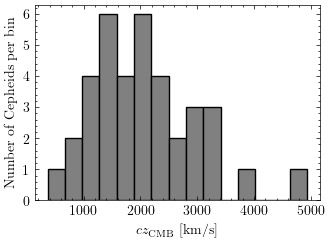

In [14]:

with plt.style.context("science"):
    plt.figure()
    plt.hist(data["czcmb_cepheid_host"], bins=15, color='gray', edgecolor='black')
    plt.xlabel(r"$cz_{\rm CMB} ~ [\mathrm{km} / \mathrm{s}]$")
    plt.ylabel("Number of Cepheids per bin")

    plt.tight_layout()
    plt.savefig(f"/Users/rstiskalek/Downloads/cepheid_host_czcmb_hist.pdf")
    plt.show()

### Hubble diagrams Cepheid-only Hubble diagrams

In [3]:
# Read-in the data
mu_host_r2 = read_samples(root, "Cepheid_distances_no_redshift_r2_mu.hdf5", "mu_host")
mu_host_r2_mag_sel = read_samples(root, "Cepheid_distances_no_redshift_r2_mu_SN_mag_sel.hdf5", "mu_host")
mu_host_unif = read_samples(root, "Cepheid_distances_no_redshift_uniform_mu.hdf5","mu_host")


mu_host_r2_mean = np.mean(mu_host_r2, axis=0)
mu_host_r2_mag_sel_mean = np.mean(mu_host_r2_mag_sel, axis=0)
mu_host_unif_mean = np.mean(mu_host_unif, axis=0)

mu_host_r2_err = np.std(mu_host_r2, axis=0)
mu_host_r2_mag_sel_err = np.std(mu_host_r2_mag_sel, axis=0)
mu_host_unif_err = np.std(mu_host_unif, axis=0)

cz = data["czcmb_cepheid_host"]
cz_err = np.ones_like(cz) * 250

/var/folders/kv/90qm_jx508j4zhvy56lhf09m0000gn/T/ipykernel_30391/3659406374.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


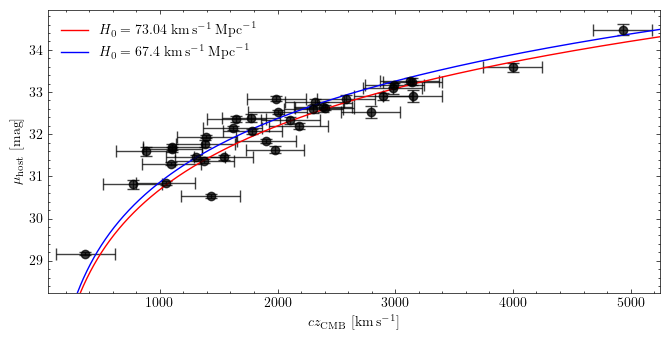

In [19]:
# Prepare the Hubble diagram plots
czrange = np.linspace(300, 5250, 1000)
zrange = czrange / SPEED_OF_LIGHT

cosmo_SH0ES = FlatLambdaCDM(H0=73.04, Om0=0.3)
mu_SH0ES = cosmo_SH0ES.distmod(czrange / SPEED_OF_LIGHT).value

cosmo_Planck = FlatLambdaCDM(H0=67.4, Om0=0.3)
mu_Planck = cosmo_Planck.distmod(czrange / SPEED_OF_LIGHT).value


# Compute SH0ES and Planck model predictions at the data cz points
mu_SH0ES_cz = np.interp(cz, czrange, mu_SH0ES)
mu_Planck_cz = np.interp(cz, czrange, mu_Planck)


m = cz < 5200

with plt.style.context("science"):
    fig, ax = plt.subplots(figsize=(6.8, 3.5))

    ax.errorbar(
        cz[m], mu_host_r2_mag_sel_mean[m], xerr=cz_err[m], yerr=mu_host_r2_mag_sel_err[m],
        fmt="o", color="black", capsize=4, alpha=0.75
    )

    ax.plot(
        czrange, mu_SH0ES, color="red",
        label=r"$H_0 = 73.04~\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$"
    )
    ax.plot(
        czrange, mu_Planck, color="blue",
        label=r"$H_0 = 67.4~\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$"
    )

    ax.set_xlabel(r"$c z_{\rm CMB} ~ [\mathrm{km}\,\mathrm{s}^{-1}]$")
    ax.set_ylabel(r"$\mu_{\rm host} ~ [\mathrm{mag}]$")
    ax.set_xlim(50, 5250)
    ax.set_ylim(mu_Planck.min())
    # ax.set_xscale("log")
    ax.legend()

    fig.tight_layout()
    fig.savefig("/Users/rstiskalek/Downloads/mu_host_cz.pdf", dpi=500, bbox_inches="tight")
    fig.show()

### Comparison of Cepheid-only distance

SH0ES_fiducial.hdf5: H0, M_B, M_W, Z_W, b_W, dZP, mu_LMC, mu_M31, mu_N4258, mu_host
Cepheid_distances_no_redshift_uniform_mu.hdf5: M_W, Z_W, b_W, dZP, mu_LMC, mu_M31, mu_N4258, mu_host
Cepheid_distances_no_redshift_r2_mu.hdf5: M_W, Z_W, b_W, dZP, mu_LMC, mu_M31, mu_N4258, mu_host
Cepheid_distances_no_redshift_r2_mu_SN_mag_sel.hdf5: M_B, M_W, Z_W, b_W, dZP, mu_LMC, mu_M31, mu_N4258, mu_host
Cepheid_distances_no_redshift_r2_mu_Cepheid_mag_sel.hdf5: M_W, Z_W, b_W, dZP, mu_LMC, mu_M31, mu_N4258, mu_host
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in
2025-07-21 15:25:28 [INFO] Saving GetDist triangle plot to: /Users/rstiskalek/Downloads/anchor_distances.pdf


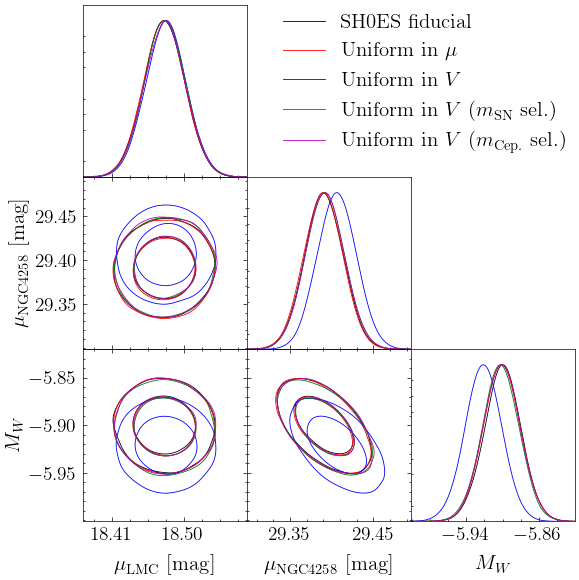

In [96]:
fnames = [
    "SH0ES_fiducial.hdf5",
    "Cepheid_distances_no_redshift_uniform_mu.hdf5",
    "Cepheid_distances_no_redshift_r2_mu.hdf5",
    "Cepheid_distances_no_redshift_r2_mu_SN_mag_sel.hdf5",
    "Cepheid_distances_no_redshift_r2_mu_Cepheid_mag_sel.hdf5",
]
labels = [
    "SH0ES fiducial",
    r"Uniform in $\mu$",
    r"Uniform in $V$",
    r"Uniform in $V$ ($m_{\rm SN}$ sel.)",
    r"Uniform in $V$ ($m_{\rm Cep.}$ sel.)",
]

fnames = [join(root, fname) for fname in fnames]


candel.plot_corner_from_hdf5(
    fnames,
    keys=["mu_LMC", "mu_N4258", "M_W"],
    labels=labels,
    filled=False,
    fontsize=18,
    filename="/Users/rstiskalek/Downloads/anchor_distances.pdf",
    )

### M_W calibration

In [6]:
M_HST, e_M_HST = data["M_HST"], data["e_M_HST"]
M_Gaia, e_M_Gaia = data["M_Gaia"], data["e_M_Gaia"]

print("M_HST: ", M_HST, "±", e_M_HST)
print("M_Gaia: ", M_Gaia, "±", e_M_Gaia)

M_HST:  -5.803876 ± 0.08194048719540387
M_Gaia:  -5.9034147 ± 0.025000005541368706


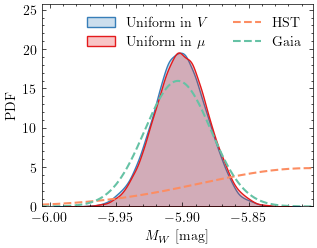

In [14]:
M_HST, e_M_HST = data["M_HST"], data["e_M_HST"]
M_Gaia, e_M_Gaia = data["M_Gaia"], data["e_M_Gaia"]
samples_r2 = read_samples(root, "Cepheid_distances_no_redshift_r2_mu_SN_mag_sel.hdf5", "M_W")
samples_uniform = read_samples(root, "Cepheid_distances_no_redshift_uniform_mu.hdf5", "M_W")


with plt.style.context("science"):
    plt.figure()
    lw = plt.rcParams["lines.linewidth"]

    # Plot KDEs instead of histograms
    sns.kdeplot(samples_r2, fill=True, label=r"Uniform in $V$", color="#377eb8", zorder=-1)
    sns.kdeplot(samples_uniform, fill=True, label=r"Uniform in $\mu$", color="#e41a1c", zorder=-1)

    # Plot Gaussian priors for HST and Gaia
    xlim = plt.xlim()
    x = np.linspace(*xlim, 500)

    plt.plot(x, norm.pdf(x, loc=M_HST, scale=e_M_HST), color="#fc8d62", label="HST", ls="--" , lw=1.5 * lw)
    plt.plot(x, norm.pdf(x, loc=M_Gaia, scale=e_M_Gaia), color="#66c2a5", label="Gaia", ls="--", lw=1.5 * lw)

    plt.xlim(*xlim)
    ymin, ymax = plt.ylim()
    plt.ylim(ymin, ymax * 1.25)  # Increase by 20%

    plt.xlabel(r"$M_W ~ [\mathrm{mag}]$")
    plt.ylabel(r"PDF")

    plt.legend(ncols=2)
    plt.savefig("/Users/rstiskalek/Downloads/M_W_distributions.pdf", dpi=500, bbox_inches="tight")
    plt.show()


### NGC 4258 calibration

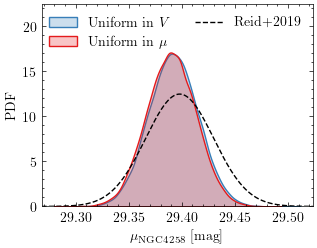

In [16]:
mean = data["mu_N4258_anchor"]
err = data["e_mu_N4258_anchor"]

samples_r2 = read_samples(root, "Cepheid_distances_no_redshift_r2_mu_SN_mag_sel.hdf5", "mu_N4258")
samples_uniform = read_samples(root, "Cepheid_distances_no_redshift_uniform_mu.hdf5", "mu_N4258")

with plt.style.context("science"):
    plt.figure()
    lw = plt.rcParams["lines.linewidth"]

    # Plot KDEs instead of histograms
    sns.kdeplot(samples_r2, fill=True, label=r"Uniform in $V$", color="#377eb8", zorder=-1)
    sns.kdeplot(samples_uniform, fill=True, label=r"Uniform in $\mu$", color="#e41a1c", zorder=-1)

    # Plot Gaussian priors for HST and Gaia
    xlim = plt.xlim()
    x = np.linspace(*xlim, 500)

    plt.plot(x, norm.pdf(x, loc=mean, scale=err), color="black", label="Reid+2019", ls="--")
    # plt.plot(x, norm.pdf(x, loc=M_Gaia, scale=e_M_Gaia), color="#66c2a5", label="Gaia", ls="--", lw=1.5 * lw)

    plt.xlim(*xlim)
    ymin, ymax = plt.ylim()
    plt.ylim(ymin, ymax * 1.25)  # Increase by 20%

    plt.xlabel(r"$\mu_{\rm NGC4258} ~ [\mathrm{mag}]$")
    plt.ylabel(r"PDF")

    plt.legend(ncols=2)
    plt.savefig("/Users/rstiskalek/Downloads/mu_NGC4258.pdf", dpi=500, bbox_inches="tight")
    plt.show()


### Cepheid-host galaxies distance comparison

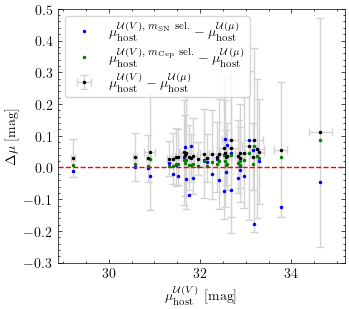

Δμ_unif    = 0.0445 ± 0.1456
Δμ_SN      = -0.0049 ± 0.1292
Δμ_Cepheid = 0.0218 ± 0.1456


In [108]:
# Load samples: shape (n_samples, 37)
mu_r2          = read_samples(root, "Cepheid_distances_no_redshift_r2_mu.hdf5", "mu_host")
mu_r2_SN       = read_samples(root, "Cepheid_distances_no_redshift_r2_mu_SN_mag_sel.hdf5", "mu_host")
mu_r2_Cepheid  = read_samples(root, "Cepheid_distances_no_redshift_r2_mu_Cepheid_mag_sel.hdf5", "mu_host")
mu_unif        = read_samples(root, "Cepheid_distances_no_redshift_uniform_mu.hdf5", "mu_host")

# Compute statistics for each host
mu_r2_mean        = mu_r2.mean(axis=0)
mu_r2_std         = mu_r2.std(axis=0)
mu_unif_mean      = mu_unif.mean(axis=0)
mu_unif_std       = mu_unif.std(axis=0)
mu_r2_SN_mean     = mu_r2_SN.mean(axis=0)
mu_r2_SN_std      = mu_r2_SN.std(axis=0)
mu_r2_Cepheid_mean = mu_r2_Cepheid.mean(axis=0)
mu_r2_Cepheid_std  = mu_r2_Cepheid.std(axis=0)

# Differences and uncertainties
diff_unif = mu_r2_mean - mu_unif_mean
err_unif  = np.sqrt(mu_r2_std**2 + mu_unif_std**2)

diff_SN   = mu_r2_SN_mean - mu_unif_mean
err_SN    = np.sqrt(mu_r2_SN_std**2 + mu_unif_std**2)

diff_Cepheid = mu_r2_Cepheid_mean - mu_unif_mean
err_Cepheid  = np.sqrt(mu_r2_Cepheid_std**2 + mu_unif_std**2)

with plt.style.context("science"):
    plt.figure(figsize=(6.8 / 2, 3))

    # With errorbars
    plt.errorbar(
        mu_r2_mean, diff_unif,
        xerr=mu_r2_std, yerr=err_unif,
        fmt='o', color='black',
        ecolor='lightgray', capsize=3, ms=1.5,
        label=r"$\mu_{\rm host}^{\mathcal{U}(V)} - \mu_{\rm host}^{\mathcal{U}(\mu)}$"
    )

    # Without errorbars
    plt.plot(
        mu_r2_mean, diff_SN, 'o', color='blue', ms=1.5,
        label=r"$\mu_{\rm host}^{\mathcal{U}(V),\,m_{\rm SN}~\mathrm{sel.}} - \mu_{\rm host}^{\mathcal{U}(\mu)}$"
    )
    plt.plot(
        mu_r2_mean, diff_Cepheid, 'o', color='green', ms=1.5,
        label=r"$\mu_{\rm host}^{\mathcal{U}(V),\,m_{\rm Cep}~\mathrm{sel.}} - \mu_{\rm host}^{\mathcal{U}(\mu)}$"
    )

    plt.axhline(0, color="red", linestyle="--")
    plt.xlabel(r"$\mu_{\rm host}^{\mathcal{U}(V)} ~ [\mathrm{mag}]$")
    plt.ylabel(r"$\Delta \mu ~ [\mathrm{mag}]$")
    plt.ylim(-0.3, 0.5)
    plt.legend(frameon=True)
    plt.tight_layout(pad=0)
    plt.savefig("/Users/rstiskalek/Downloads/mu_host.pdf", bbox_inches='tight')
    plt.show()

print(f"Δμ_unif    = {diff_unif.mean():.4f} ± {err_unif.mean():.4f}")
print(f"Δμ_SN      = {diff_SN.mean():.4f} ± {err_SN.mean():.4f}")
print(f"Δμ_Cepheid = {diff_Cepheid.mean():.4f} ± {err_Cepheid.mean():.4f}")

### Effect of distance selection on distances

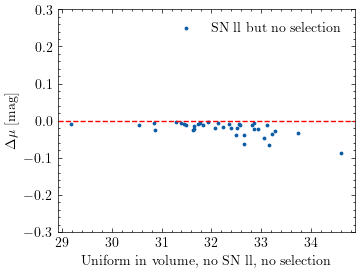

dx = -0.0218 ± 0.1456


In [102]:
# samples_r2 = read_samples(root, "Cepheid_distances_no_redshift_r2_mu.hdf5", "mu_host")
samples_r2 = read_samples(root, "Cepheid_distances_no_redshift_r2_mu_Cepheid_mag_sel.hdf5", "mu_host")
# samples_r2_SN_sel = read_samples(root, "Cepheid_distances_no_redshift_r2_mu_SN_mag_sel.hdf5", "mu_host")
# samples_r2 = read_samples(root, "Cepheid_distances_no_redshift_r2_mu_SN_mag_sel.hdf5", "mu_host")
# samples_r2_SN_sel = read_samples(root, "Cepheid_distances_no_redshift_r2_SN_ll_no_sel.hdf5", "mu_host")

samples_r2_SN_all = read_samples(root, "Cepheid_distances_no_redshift_uniform_mu.hdf5", "mu_host")

ntot = 37

X = {f"mu_{i}": samples_r2[:, i] for i in range(ntot)}
# Y = {f"mu_{i}": samples_r2_SN_sel[:, i] for i in range(ntot)}

Y = {f"mu_{i}": samples_r2_SN_all[:, i] for i in range(ntot)}

x_mean = np.asarray([np.mean(X[f"mu_{i}"]) for i in range(ntot)])
x_err = np.asarray([np.std(X[f"mu_{i}"]) for i in range(ntot)])

dy1_mean = np.asarray([np.mean(Y[f"mu_{i}"]) - np.mean(X[f"mu_{i}"]) for i in range(ntot)])
dy1_err = np.asarray([np.sqrt(np.var(Y[f"mu_{i}"]) + np.var(X[f"mu_{i}"])) for i in range(ntot)])

dy2_mean = np.asarray([np.mean(Y2[f"mu_{i}"]) - np.mean(X[f"mu_{i}"]) for i in range(ntot)])


with plt.style.context("science"):
    plt.figure()
    plt.scatter(x_mean, dy1_mean, s=3, label=r"SN ll but no selection")
    # plt.scatter(x_mean, dy2_mean, s=3, label=r"SN ll and selection")
    # plt.errorbar(x_mean, dy1_mean, xerr=x_err, yerr=dy1_err, fmt='o', color='black',
    #              ecolor='lightgray',  capsize=3, ms=1.5,
    #             #  label=r"$\mu_{\rm host}^{\mathcal{U}(V),\,m_{\rm SN}~\mathrm{sel.}} - \mu_{\rm host}^{\mathcal{U}(V)}$"
    #              )

    plt.axhline(0, color="red", linestyle="--", )
    plt.xlabel(r"Uniform in volume, no SN ll, no selection")
    plt.ylabel(r"$\Delta \mu ~ [\mathrm{mag}]$")
    plt.ylim(-0.3, 0.3)
    plt.legend()

    plt.tight_layout(pad=0)
    plt.savefig("/Users/rstiskalek/Downloads/mu_host_sel_test.png", bbox_inches='tight', dpi=450)

    plt.show()


print(f"dx = {dy1_mean.mean():.4f} ± {dy1_err.mean():.4f}")
# print(f"dx = {dy2_mean.mean():.4f} ± {dy2_err.mean():.4f}")

### C15 all-parameters

Cepheid_H0_Manticore_SN_sel.hdf5: H0, M_B, M_W, Vext, Vext_b, Vext_ell, Vext_mag, Z_W, b_W, dZP, mu_LMC, mu_M31, mu_N4258, mu_host, sigma_v
Removed no burn in
2025-07-18 19:31:47 [INFO] Saving GetDist triangle plot to: /Users/rstiskalek/Downloads/Manticore_corner.pdf


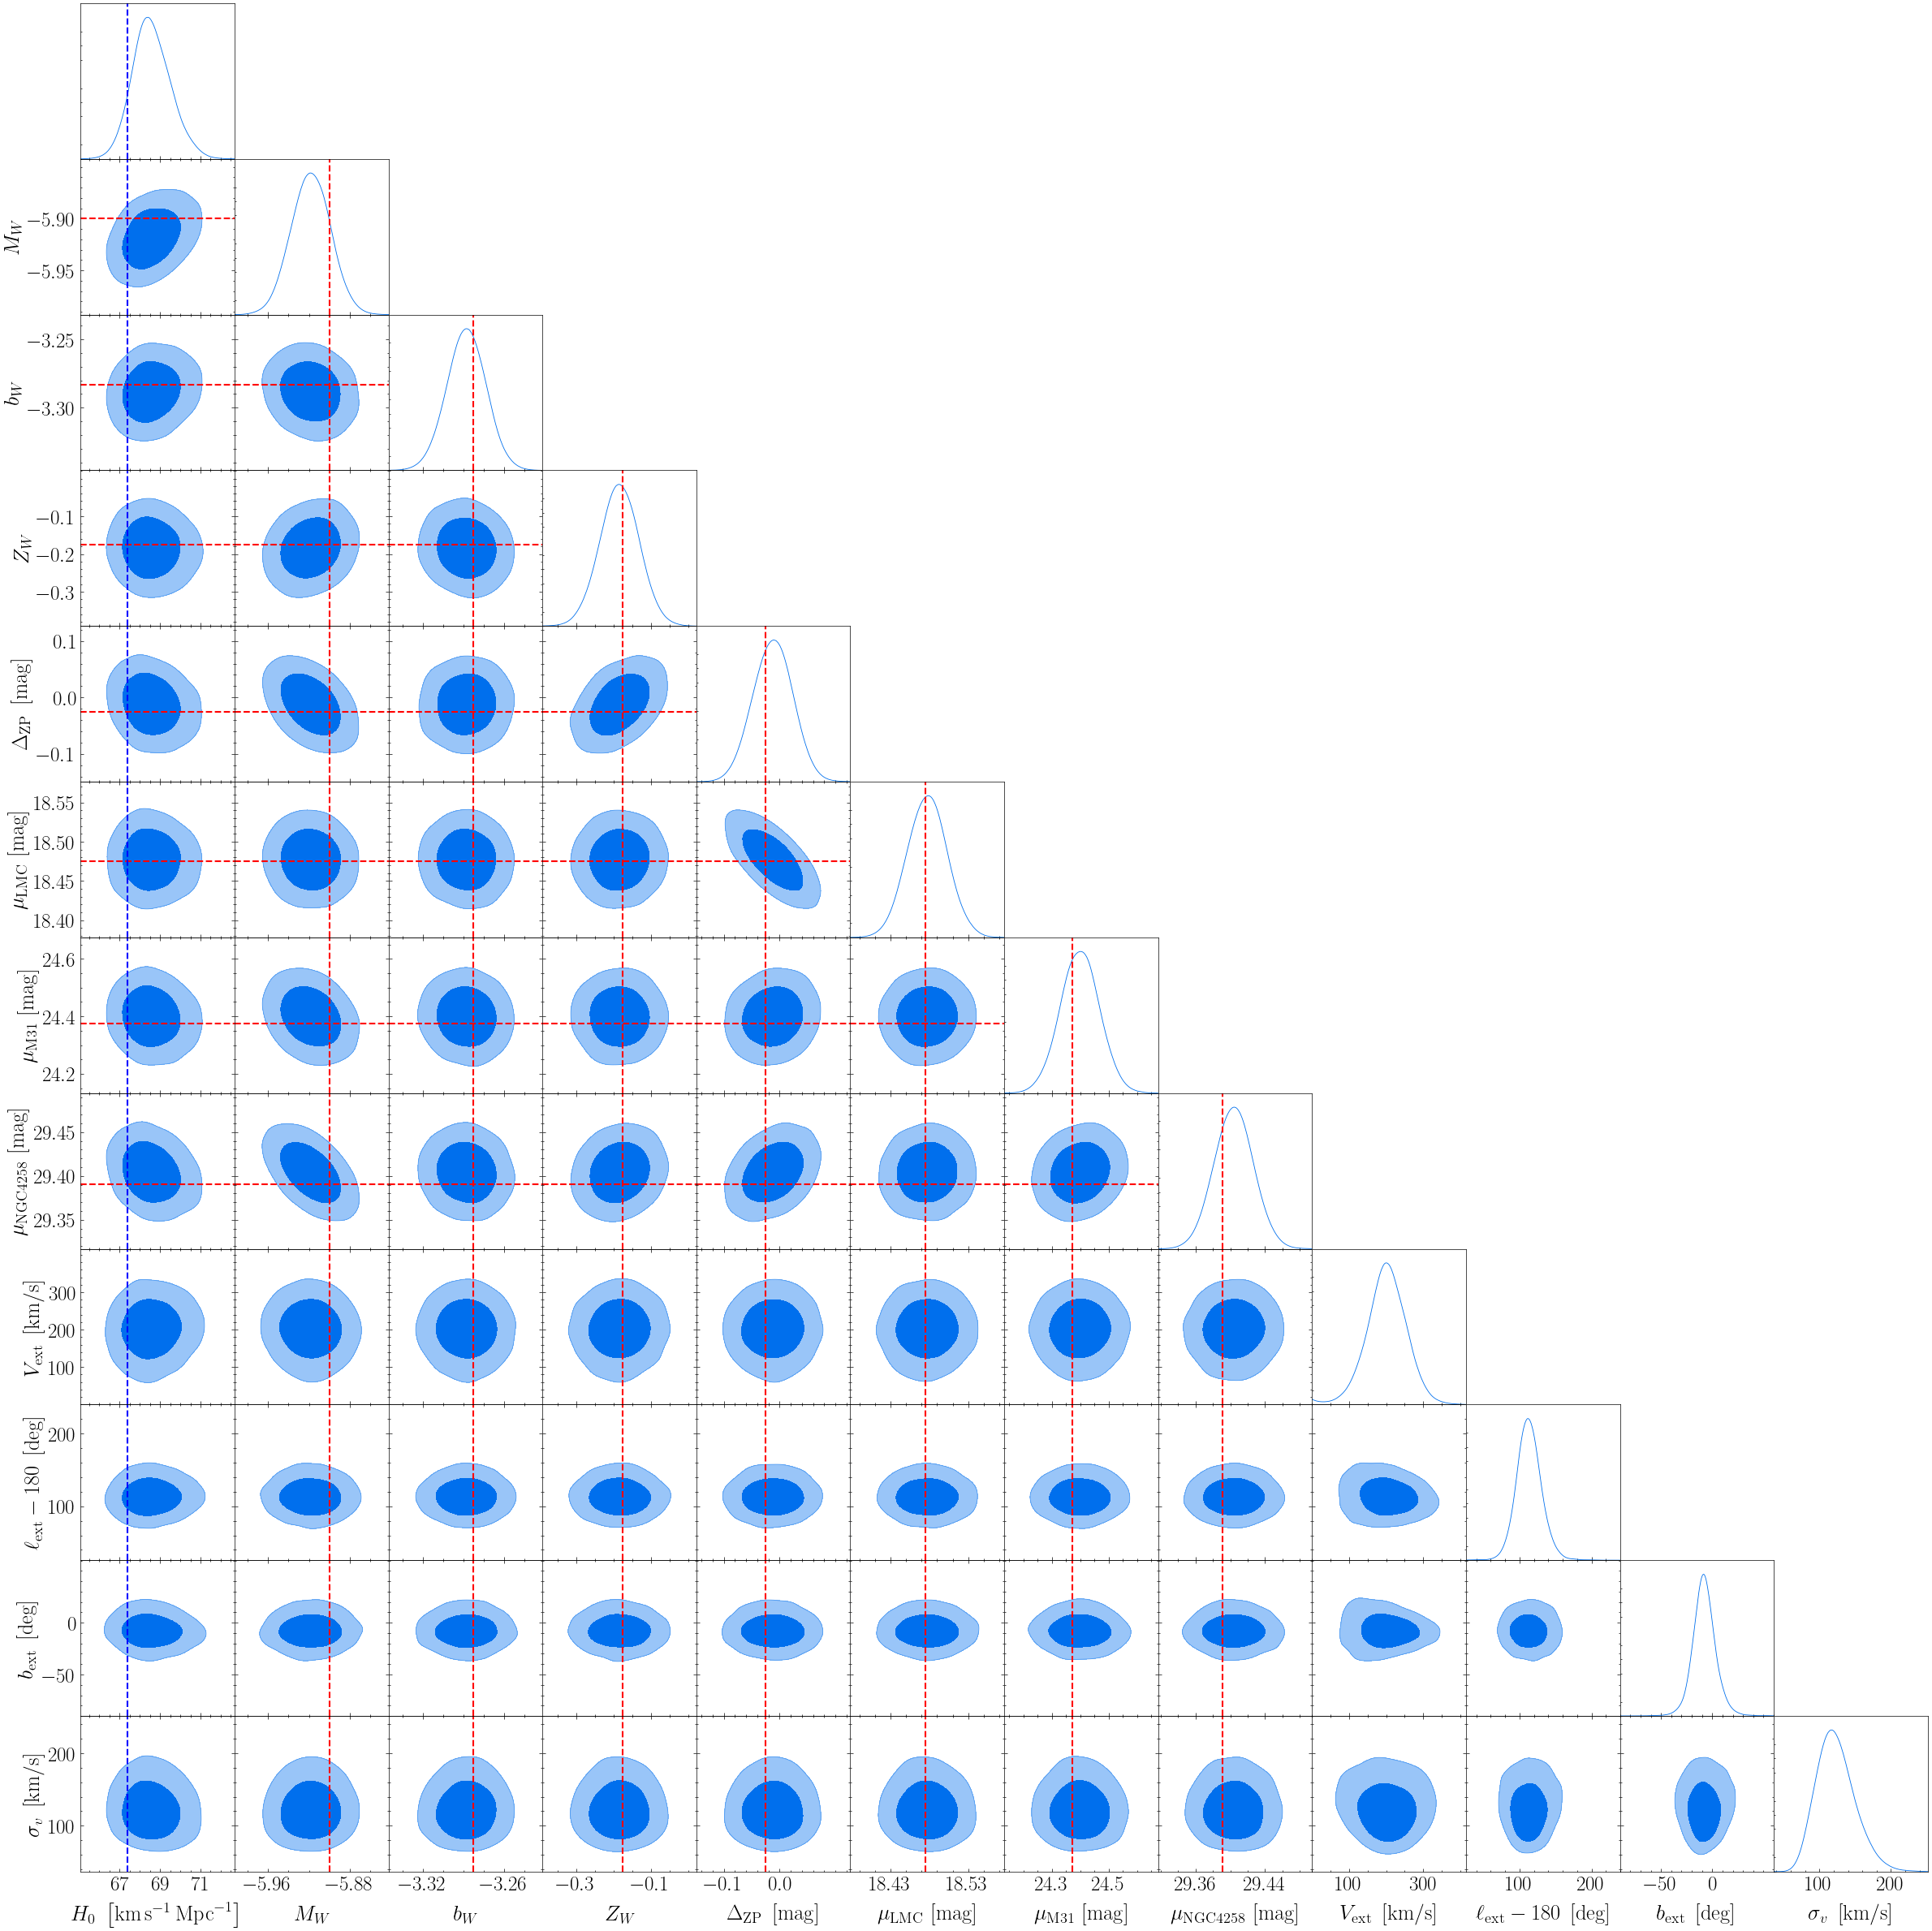

In [49]:
fnames = [
    "Cepheid_H0_Manticore_SN_sel.hdf5",
    ]

labels = None

fnames = [join(root, fname) for fname in fnames]

truths_SH0ES = {"H0": 73.04, "M_W": -5.8999543, "b_W": -3.2831473,
          "Z_W": -0.17501639, "dZP": -0.025033418, "mu_LMC": 18.475368,
          "mu_N4258": 29.390965, "mu_M31": 24.373648,}
truths_Planck = {"H0": 67.4,}
# truths_Carrick = {"beta": 0.43, "Vext_mag": 159, "Vext_ell": 304 - 180, "Vext_b": 6}

truths = [
    {"dict": truths_SH0ES, "color": "red"},
    {"dict": truths_Planck, "color": "blue",},
    # {"dict": truths_Carrick, "color": "green", "label": "Carrick+2023"},
]


candel.plot_corner_from_hdf5(
    fnames,
    keys=["H0", "M_W", "b_W", "Z_W", "dZP", "mu_LMC", "mu_M31", "mu_N4258", "beta", "Vext_mag", "Vext_ell", "Vext_b", "sigma_v"],
    labels=labels,
    apply_ell_offset=True,
    ell_range=[None, None],
    filename="/Users/rstiskalek/Downloads/Manticore_corner.pdf",
    fontsize=22,
    truths=truths,
    )

### Comparison of all inferred $H_0$ values

In [46]:
fnames = [
    "Cepheid_H0_Manticore_SN_sel.hdf5",
    "Cepheid_H0_Manticore_redshift_sel.hdf5",
    "Cepheid_H0_C15_SN_sel.hdf5",
    "Cepheid_H0_C15_redshift_sel.hdf5",
    # "Cepheid_H0_sigma_v_Vext_SN_sel.hdf5",
    # "Cepheid_H0_sigma_v_Vext_redshift_sel.hdf5",
    # "Cepheid_H0_C15.hdf5",
    # "Cepheid_H0_PV_covmat.hdf5",
    # "Cepheid_H0_Vext_sigma_v.hdf5",
    # "Cepheid_H0_sigma_v.hdf5",
    # "Cepheid_H0_PV_covmat_scaled.hdf5",
]
labels = [
    "Manticore PVs (SN sel.)",
    "Manticore PVs (redshift sel.)",
    "Carrick+2015 PVs (SN sel.)",
    "Carrick+2015 PVs (redshift sel.)",
    # r"$\boldsymbol{V}_{\rm ext},\,\sigma_v$ (SN sel.)",
    # r"$\boldsymbol{V}_{\rm ext},\,\sigma_v$ (redshift sel.)",
    # r"PVs from Carrick+2015, $\boldsymbol{V}_{\rm ext}$, diagonal covariance",
    # r"$\langle V_{\rm pec}\rangle = 0$, $\Lambda$CDM covariance",
    # r"$\boldsymbol{V}_{\rm ext}$, diagonal covariance",
    # r"$\langle V_{\rm pec}\rangle = 0$, diagonal covariance",
    # r"Cepheids only (uniform in volume prior)",
    # r"Cepheids only (uniform in $\mu$ prior)",
    # r"Cepheids full",
]



samples = [read_samples(root, fname, "H0") for fname in fnames]

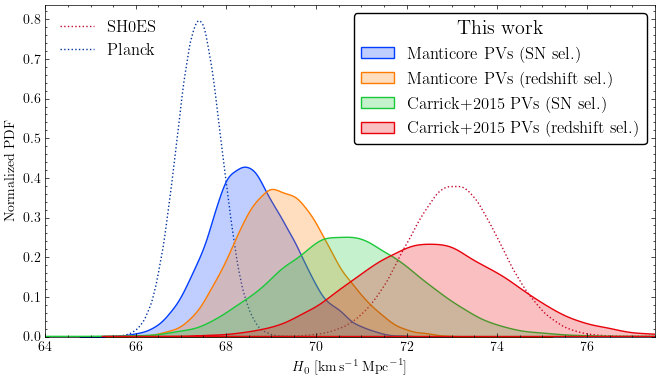

In [48]:
fig_width = 6.8  # in inches
fig_height = 4

filtered_palette = sns.color_palette("bright")
# filtered_palette = set1_palette[2:]  # skip red (0) and blue (1)

with plt.style.context("science"):
    plt.figure(figsize=(fig_width, fig_height))

    for i in range(len(samples)):
        sns.kdeplot(
            samples[i],
            label=labels[i],
            fill=True,
            color=filtered_palette[i % len(filtered_palette)]
        )

    sns.kdeplot(
        norm(73.04, 1.04).rvs(size=500000),
        label="SH0ES",
        fill=False,
        # alpha=0.2,
        ls="dotted",
        color="#BF0A30",
        zorder=-1,
    )
    sns.kdeplot(
        norm(67.4, 0.5).rvs(size=500000),
        label="Planck",
        fill=False,
        # alpha=0.2,
        ls="dotted",
        color="#003399",
        zorder=-1,
    )

    # plt.text(
    # 0.5, 0.5, "PRELIMINARY",
    # fontsize=48, color='gray', alpha=0.5,
    # ha='center', va='center', zorder=10,
    # transform=plt.gcf().transFigure, rotation=30)

    plt.xlabel(r"$H_0 ~ [\mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}]$")
    plt.ylabel("Normalized PDF")
    # plt.legend(ncol=1, fontsize="large")

    ax = plt.gca()

    # Get all handles and labels
    handles, labels_all = ax.get_legend_handles_labels()

    # Separate by label
    main_handles = []
    main_labels = []
    ref_handles = []
    ref_labels = []

    for h, l in zip(handles, labels_all):
        if l in ["SH0ES", "Planck"]:
            ref_handles.append(h)
            ref_labels.append(l)
        else:
            main_handles.append(h)
            main_labels.append(l)

    legend1 = ax.legend(
        main_handles, main_labels,
        loc="upper right",
        fontsize="large",
        title="This work",
        title_fontsize="x-large",
        frameon=True,
        edgecolor='black',
        facecolor='white',
        fancybox=True,
        framealpha=1
    )
    ax.add_artist(legend1)
    ax.legend(ref_handles, ref_labels, loc="upper left", fontsize="large")


    plt.xlim(64, 77.5)
    plt.tight_layout()
    plt.savefig("/Users/rstiskalek/Downloads/H0_comparison.pdf", dpi=500, bbox_inches="tight")
    plt.show()

### Selection bias test

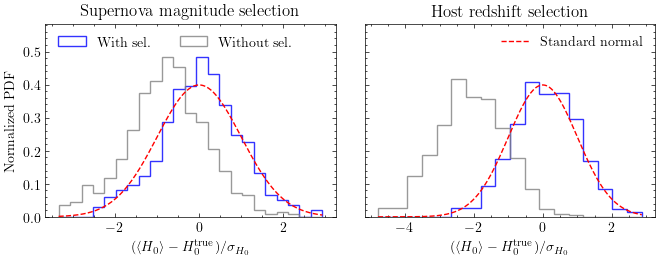

In [65]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from os.path import join

root_here = "/Users/rstiskalek/Projects/CANDEL/results/CH0/bias_test"

with plt.style.context("science"):
    fig, axes = plt.subplots(1, 2, figsize=(6.8, 2.8), sharey=True)

    hist_kwargs = {
        "alpha": 0.8,
        "histtype": "step",
        "density": True,   # <--- key change here
        }

    # --- Supernova magnitude selection ---
    data_SN_acc = np.load(join(root_here, "H0_bias_SN_selection.npy"))
    data_SN_not = np.load(join(root_here, "H0_bias_SN_selection_not_accountted.npy"))
    all_data_SN = np.concatenate([data_SN_acc, data_SN_not])
    bins_SN = np.histogram_bin_edges(all_data_SN, bins="auto")

    axes[0].hist(data_SN_acc, bins=bins_SN, label="With sel.", **hist_kwargs, color="blue")
    axes[0].hist(data_SN_not, bins=bins_SN, label="Without sel.", **hist_kwargs, color="gray")
    axes[0].set_title("Supernova magnitude selection")
    axes[0].set_xlabel(r"$(\langle H_0 \rangle - H_0^{\rm true})/\sigma_{H_0}$")
    # Standard normal overlay (density=1)
    x_SN = np.linspace(bins_SN[0], bins_SN[-1], 200)
    axes[0].plot(x_SN, norm.pdf(x_SN), ls="--", color="red")
    axes[0].legend(loc="upper left", ncol=2,)


    # --- Host redshift selection ---
    data_z_acc = np.load(join(root_here, "H0_bias_redshift_selection.npy"))
    data_z_not = np.load(join(root_here, "H0_bias_redshift_selection_not_accounted.npy"))
    all_data_z = np.concatenate([data_z_acc, data_z_not])
    bins_z = np.histogram_bin_edges(all_data_z, bins="auto")

    axes[1].hist(data_z_acc, bins=bins_z, **hist_kwargs, color="blue")
    axes[1].hist(data_z_not, bins=bins_z, **hist_kwargs, color="gray")
    axes[1].set_title("Host redshift selection")
    axes[1].set_xlabel(r"$(\langle H_0 \rangle - H_0^{\rm true})/\sigma_{H_0}$")

    # Standard normal overlay (density=1)
    x_z = np.linspace(bins_z[0], bins_z[-1], 200)
    axes[1].plot(x_z, norm.pdf(x_z), ls="--", color="red", label="Standard normal")

    axes[0].set_ylabel("Normalized PDF")
    axes[1].legend()

    ylim = axes[0].get_ylim()
    axes[1].set_ylim(ylim[0], 1.15 * ylim[1])

    plt.tight_layout()
    plt.savefig("/Users/rstiskalek/Downloads/H0_bias_selection.pdf", dpi=500, bbox_inches="tight")
    plt.show()

### Read off values for a table

In [118]:

# x = read_samples(root, "Cepheid_distances_mu_uniform.hdf5", "mu_N4258")


# fname = "Cepheid_H0_C15_<X>.hdf5"
fname = "Cepheid_H0_scaled_PV_covmat_<X>.hdf5"

# for key in ["no_sel", "redshift_sel", "SN_sel", "joint_sel", "Cepheid_mag_sel"]:
for key in ["no_sel", "redshift_sel", "SN_sel", "Cepheid_mag_sel"]:
    fname_i = fname.replace("<X>", key)
    x = read_samples(root, fname_i, "H0")

    mu = x.mean()
    std = x.std()

    print(key, f"${mu:.1f} \\pm {std:.1f}$")

no_sel $67.6 \pm 3.1$
redshift_sel $86.2 \pm 4.5$
SN_sel $69.9 \pm 3.0$
Cepheid_mag_sel $68.3 \pm 3.1$


In [19]:
from scipy.stats import norm
import posterior_agreement

# x = read_samples(root, "Cepheid_H0_Vext_sigma_v.hdf5", "H0")
# x = norm(72.59, 1.71).rvs(50000)
H0_planck = norm(67.4, 0.5).rvs(50000)
H0_SH0ES = norm(73.04, 1.04).rvs(50000)

print(x.mean(), x.std())

chains = (H0_SH0ES, x)
agreement_1d = posterior_agreement.compute_agreement(chains)
print("SH0ES: p-value %.3f, corresponding to %.4f sigmas"%(agreement_1d.PTE, agreement_1d.sigma))

chains = (H0_planck, x)
agreement_1d = posterior_agreement.compute_agreement(chains)
print("Planck: p-value %.3f, corresponding to %.4f sigmas"%(agreement_1d.PTE, agreement_1d.sigma))

69.29531 1.0527997
SH0ES: p-value 0.013, corresponding to 2.4718 sigmas
Planck: p-value 0.103, corresponding to 1.6317 sigmas
